# Unsupervised Clustering of Pet Photos

### What am i doing in this notebook?

In this notebook, I will explore how I can give the computer a group of pet images, and it can cluster the ones with the same animals together.

I will be doing that by encoding the images through a trained convolutional network, and then apply a clustering algorithm to the encoded features. We can then check the clusters and see if it worked!

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Let's import the libraries we'll need

Keras is using a TensorFlow backend in our case here.

In [1]:
%matplotlib inline

import time
import os, os.path
import random
import cv2
import glob
import keras
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

import pandas as pd
import numpy as np
import zipfile

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
                                    # (nothing gets printed in Jupyter, only if you run it standalone)
sess = tf.compat.v1.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras


#DIR = "c:\\tmp\\cnn\\data"
DIR = "seeds"

#with zipfile.ZipFile("DbImages.zip", 'r') as zip_ref:
#    zip_ref.extractall("DIR")


1 Physical GPUs, 1 Logical GPUs
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2060, pci bus id: 0000:0e:00.0, compute capability: 7.5



## Dataset information

Pet images are in directories with the following format:

Character + Number + '-' + breed name.

Character is either C or D for cat or dog. Number is a serial number for the breed. No two breeds of the same animal have the same number.

Examples: 

C1-Abyssinian
D6-Chiuahua

We will use this information to list the breeds available and count the number of images available for each.

In [2]:
# directory where images are stored
def dataset_stats():
    
    # This is an array with the letters available.
    # If you add another animal later, you will need to structure its images in the same way
    # and add its letter to this array
    animal_characters = ['N', 'R']
    
    # dictionary where we will store the stats
    stats = []
    
    for animal in animal_characters:
        # get a list of subdirectories that start with this character
        directory_list = sorted(glob.glob("{}/[{}]*".format(DIR, animal)))
        
        for sub_directory in directory_list:
            file_names = [file for file in os.listdir(sub_directory)]
            file_count = len(file_names)
            sub_directory_name = os.path.basename(sub_directory)
            stats.append({ "Code": sub_directory_name[:sub_directory_name.find('-')],
                            "Image count": file_count, 
                           "Folder name": os.path.basename(sub_directory),
                            "File names": file_names})
    
    
    df = pd.DataFrame(stats)
    
    return df

In [3]:
# Show codes with their folder names and image counts
dataset = dataset_stats().set_index("Code")
dataset[["Folder name", "Image count"]]

,Folder name,Image count
Code,,
N1,N1-Nocciole_Intere,71
N2,N2-Nocciole_Gusci,47
N3,N3-Nocciole_Marce,18
R10,R10-Riso_Bono,137
R11,R11-Riso_Bono,138
R20,R20-Riso_Rotto,170
R21,R21-Riso_Rotto,150
R22,R22-Riso_unito,1052
R30,R30-Riso_Unito,136


### Loading the images

Now we create a function that loads all images in a directory for a given array of codes in one array and creates the corresponding label array for them.

Loaded images are resized to 224 x 224 before storing them in our array since this is the size preferred by VGG19 which we will be using later.

In [4]:
# Function returns an array of images whoose filenames start with a given set of characters
# after resizing them to 224 x 224

def load_images(codes, clumpW = 100, clumpH = 100):
    
    # Define empty arrays where we will store our images and labels
    images = []
    images1 = []
    labels = []
    sizes = []
    wMax = 0
    hMax = 0
    
    for code in codes:
        # get the folder name for this code
        folder_name = dataset.loc[code]["Folder name"]
        
        for file in dataset.loc[code]["File names"]:                 
            # build file path
            file_path = os.path.join(DIR, folder_name, file)
            
            # Read the image
            image = cv2.imread(file_path)
            w, h, d = image.shape
            
            # discard bigger in any dim of 150
            if w < clumpW and h < clumpH:

                wMax = max(wMax, w)
                hMax = max(hMax, h)    
            
                # Resize it to 224 x 224
                # image = cv2.resize(image, (224,224))

                # Convert it from BGR to RGB so we can plot them later (because openCV reads images as BGR)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                # Now we add it to our array
                images.append(image)
                labels.append(code)

    print( f'{wMax} x {hMax}')

    k = 224 / max(wMax, hMax)

    #resize images
    for img in images:
        w, h, d = img.shape

        # resize by k
        image = cv2.resize(img, (round(k * w), round(k * h)))
        w, h, d = image.shape

        xoff = round((224 - w) / 2)
        yoff = round((224 - h) / 2)

        # make empty image
        blank_image = np.zeros((224, 224, 3), np.uint8)
        blank_image[xoff:xoff+w, yoff:yoff+h] = image
        images1.append(blank_image)

    return images1, labels

#### Now we chose our codes for the breeds that we want and load the images and labels

I will chose two cat breeds and two dog breeds. While working on the whole dataset would yield more interesting results, it requires more memory than my computer has.

In [5]:
codes = ["N1", "R10"]
images, labels = load_images(codes, 150, 150)

114 x 132


### Photo time!

Let's have a look at the breeds we loaded! The photos will not be in their original aspect ratio since we've resized them to fit what VGG needs

In [6]:
def show_random_images(images, labels, number_of_images_to_show=5):

    for code in list(set(labels)):

        indicies = [i for i, label in enumerate(labels) if label == code]
        random_indicies = [random.choice(indicies) for i in range(number_of_images_to_show)]
        figure, axis = plt.subplots(1, number_of_images_to_show)

        print("{} random images for code {}".format(number_of_images_to_show, code))

        for image in range(number_of_images_to_show):
            axis[image].imshow(images[random_indicies[image]])
        plt.show()

5 random images for code R10


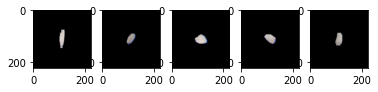

5 random images for code N1


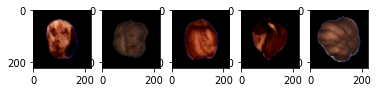

In [7]:
show_random_images(images, labels)

### Normalise...

We now convert the images and labels to NumPy arrays to make processing them easier. We then normaise the images before passing them on to VGG19

In [8]:
def normalise_images(images, labels):

    # Convert to numpy arrays
    images = np.array(images, dtype=np.float32)
    labels = np.array(labels)

    # Normalise the images
    images /= 255
    
    return images, labels

In [9]:
images, labels = normalise_images(images, labels)

### Time to mix it up!

Now that we have all the photos and their labels in arrays. It's time to shuffle them around, and split them to three different sets... training, validation and testing.

We'll be using the `train_test_split` function from sklearn which will also shuffle the data around for us, since it's currently in order.

In [10]:
def shuffle_data(images, labels):

    # Set aside the testing data. We won't touch these until the very end.
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=1, random_state=728)
    
    return X_train, y_train

In [11]:
X_train, y_train = shuffle_data(images, labels)

### Load pre-trained covnet models
#### VGG16, VG19, ResNet50

We'll now load up the keras models with the imagenet weights. We'll remove the top dense layers, since we won't need to classify things here, and we just want these encoded features from the images.

In [12]:
# Load the models with ImageNet weights

vgg16_model = keras.applications.vgg16.VGG16(include_top=False, weights="imagenet", input_shape=(224,224,3))

vgg19_model = keras.applications.vgg19.VGG19(include_top=False, weights="imagenet", input_shape=(224,224,3))

resnet50_model = keras.applications.resnet50.ResNet50(include_top=False, weights="imagenet", input_shape=(224,224,3))




### Output... falls flat

The covnet models will give us 3D vectors that represent the image. We need to flatten these for the clustering algorithms to start working with them.

In [13]:
def covnet_transform(covnet_model, raw_images):

    # Pass our training data through the network
    pred = covnet_model.predict(raw_images)

    # Flatten the array
    flat = pred.reshape(raw_images.shape[0], -1)
    
    return flat


In [14]:
vgg16_output = covnet_transform(vgg16_model, X_train)
print("VGG16 flattened output has {} features".format(vgg16_output.shape[1]))

vgg19_output = covnet_transform(vgg19_model, X_train)
print("VGG19 flattened output has {} features".format(vgg19_output.shape[1]))

resnet50_output = covnet_transform(resnet50_model, X_train)
print("ResNet50 flattened output has {} features".format(resnet50_output.shape[1]))

VGG16 flattened output has 25088 features
VGG19 flattened output has 25088 features
ResNet50 flattened output has 100352 features


The above cell shows us the number of features each covnet gives to a single image. When we compare these to the original size of the image 224 x 224 x 3 = 150,528 pixels/features, we can see that this is a large reduction in what the clustering algorithms will have to work with.

 

Hopefully these reduces number of feature are represent more meaningful features in the image structure.

### PCA

While k-means clustering has coped with these numbers, Gaussian Mixture Modelling has not and the computer consistently ran out of memory and struggled to produce results. 

We therefore look to PCA for dimensionality reduction, so that our clustering algorithms can cope.

In [15]:
# Function that creates a PCA instance, fits it to the data and returns the instance
def create_fit_PCA(data, n_components=None):
    
    p = PCA(n_components=n_components, random_state=728)
    p.fit(data)
    
    return p
    

In [16]:
# Create PCA instances for each covnet output
vgg16_pca = create_fit_PCA(vgg16_output)
vgg19_pca = create_fit_PCA(vgg19_output)
resnet50_pca = create_fit_PCA(resnet50_output)


In [17]:
# Function to plot the cumulative explained variance of PCA components
# This will help us decide how many components we should reduce our features to
def pca_cumsum_plot(pca):
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    plt.show()

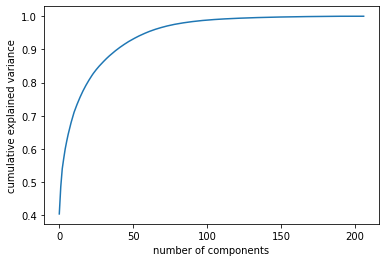

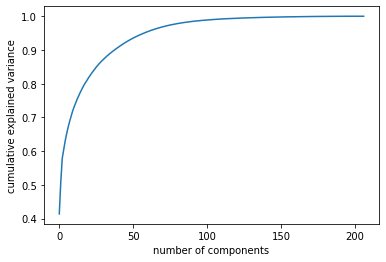

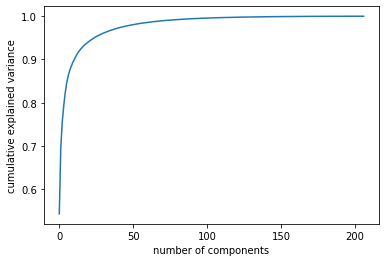

In [18]:
# Plot the cumulative explained variance for each covnet
pca_cumsum_plot(vgg16_pca)
pca_cumsum_plot(vgg19_pca)
pca_cumsum_plot(resnet50_pca)

Looking at the gaphs above, we can see that PCA can explain almost all the variance in as many dimensions as there are samples.

It is also interesting to note the difference in shape between the VGG graphs and the ResNet one. This is probably due to the fact that ResNet only had 2048 dimensions to start with, while VGGs had 25,088

In [19]:
# PCA transformations of covnet outputs
vgg16_output_pca = vgg16_pca.transform(vgg16_output)
vgg19_output_pca = vgg19_pca.transform(vgg19_output)
resnet50_output_pca = resnet50_pca.transform(resnet50_output)

### Cluster time

Let's write a couple of functions that would create and fit KMeans and Gaussian Mixture models.
While it can make sense to combine them in one function that returns both, I've seperated them so we can execute them seperately and make some observations without overloading the PC

In [20]:
def create_train_kmeans(data, number_of_clusters=len(codes)):
    # n_jobs is set to -1 to use all available CPU cores. This makes a big difference on an 8-core CPU
    # especially when the data size gets much bigger. #perfMatters
    
    k = KMeans(n_clusters=number_of_clusters, n_jobs=-1, random_state=728)

    # Let's do some timings to see how long it takes to train.
    start = time.time()

    # Train it up
    k.fit(data)

    # Stop the timing 
    end = time.time()

    # And see how long that took
    print("Training took {} seconds".format(end-start))
    
    return k

In [21]:
def create_train_gmm(data, number_of_clusters=len(codes)):
    g = GaussianMixture(n_components=number_of_clusters, covariance_type="full", random_state=728)
    
    start=time.time()
    g.fit(data)
    end=time.time()
    
    print("Training took {} seconds".format(end-start))
    
    return g
    

### Ask the clustering algo what it thinks is what

In [22]:
# Let's pass the data into the algorithm and predict who lies in which cluster. 
# Since we're using the same data that we trained it on, this should give us the training results.

# Here we create and fit a KMeans model with the PCA outputs
print("KMeans (PCA): \n")

print("VGG16")
K_vgg16_pca = create_train_kmeans(vgg16_output_pca)

print("\nVGG19")
K_vgg19_pca = create_train_kmeans(vgg19_output_pca)

print("\nResNet50")
K_resnet50_pca = create_train_kmeans(resnet50_output_pca)

KMeans (PCA): 

VGG16
Training took 0.0315244197845459 seconds

VGG19
Training took 0.02552056312561035 seconds

ResNet50
Training took 0.02602100372314453 seconds


C:\Users\Laco\.conda\envs\tf-gpu\lib\site-packages\sklearn\cluster\_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
C:\Users\Laco\.conda\envs\tf-gpu\lib\site-packages\sklearn\cluster\_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
C:\Users\Laco\.conda\envs\tf-gpu\lib\site-packages\sklearn\cluster\_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


In [23]:
# Same for Gaussian Model
print("GMM (PCA): \n")

print("VGG16")
G_vgg16_pca = create_train_gmm(vgg16_output_pca)

print("\nVGG19")
G_vgg19_pca = create_train_gmm(vgg19_output_pca)

print("\nResNet50")
G_resnet50_pca = create_train_gmm(resnet50_output_pca)


GMM (PCA): 

VGG16
Training took 0.0170133113861084 seconds

VGG19
Training took 0.015512466430664062 seconds

ResNet50
Training took 0.01401066780090332 seconds


In [24]:
# Let's also create models for the covnet outputs without PCA for comparison
print("KMeans: \n")

print("VGG16:")
K_vgg16 = create_train_kmeans(vgg16_output)

print("\nVGG19:")
K_vgg19 = create_train_kmeans(vgg19_output)

print("\nResNet50:")
K_resnet50 = create_train_kmeans(resnet50_output)


KMeans: 

VGG16:


C:\Users\Laco\.conda\envs\tf-gpu\lib\site-packages\sklearn\cluster\_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Training took 0.6840384006500244 seconds

VGG19:


C:\Users\Laco\.conda\envs\tf-gpu\lib\site-packages\sklearn\cluster\_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Training took 0.654015064239502 seconds

ResNet50:


C:\Users\Laco\.conda\envs\tf-gpu\lib\site-packages\sklearn\cluster\_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Training took 2.700627088546753 seconds


#### Attempts to run the Gaussian Mixtue Model on the outputs without PCA always give an out of memory error. I am therefore unable to test these and conclude that they are impractical to use.

In [25]:
# Now we get the custer model predictions

# KMeans with PCA outputs
k_vgg16_pred_pca = K_vgg16_pca.predict(vgg16_output_pca)
k_vgg19_pred_pca = K_vgg19_pca.predict(vgg19_output_pca)
k_resnet50_pred_pca = K_resnet50_pca.predict(resnet50_output_pca)

# KMeans with CovNet outputs
k_vgg16_pred = K_vgg16.predict(vgg16_output)
k_vgg19_pred = K_vgg19.predict(vgg19_output)
k_resnet50_pred = K_resnet50.predict(resnet50_output)

# Gaussian Mixture with PCA outputs
g_resnet50_pred_pca = G_resnet50_pca.predict(resnet50_output_pca)
g_vgg16_pred_pca = G_vgg16_pca.predict(vgg16_output_pca)
g_vgg19_pred_pca = G_vgg19_pca.predict(vgg19_output_pca)

Remember that the clustering algorith does not detect which images are cats and which are dogs, it only groups images that look alike together and assigns them a number arbitrarily. 

We now need to count how many of each label are in  each cluster, this way we can take a look and if sufficient eperation has happened we can quicly see which cluster is which label. So let's write a function that does that.

In [26]:
def cluster_label_count(clusters, labels):
    
    count = {}
    
    # Get unique clusters and labels
    unique_clusters = list(set(clusters))
    unique_labels = list(set(labels))
    
    # Create counter for each cluster/label combination and set it to 0
    for cluster in unique_clusters:
        count[cluster] = {}
        
        for label in unique_labels:
            count[cluster][label] = 0
    
    # Let's count
    for i in range(len(clusters)):
        count[clusters[i]][labels[i]] +=1
    
    cluster_df = pd.DataFrame(count)
    
    return cluster_df

In [27]:
# Cluster counting for VGG16 Means
vgg16_cluster_count = cluster_label_count(k_vgg16_pred, y_train)
vgg16_cluster_count_pca = cluster_label_count(k_vgg16_pred_pca, y_train)

# VGG19 KMeans
vgg19_cluster_count = cluster_label_count(k_vgg19_pred, y_train)
vgg19_cluster_count_pca = cluster_label_count(k_vgg19_pred_pca, y_train)

# ResNet50 KMeans
resnet_cluster_count = cluster_label_count(k_resnet50_pred, y_train)
resnet_cluster_count_pca = cluster_label_count(k_resnet50_pred_pca, y_train)

# GMM
g_vgg16_cluster_count_pca = cluster_label_count(g_vgg16_pred_pca, y_train)
g_vgg19_cluster_count_pca = cluster_label_count(g_vgg19_pred_pca, y_train)
g_resnet50_cluster_count_pca = cluster_label_count(g_resnet50_pred_pca, y_train)

print(X_train[:10])
print(g_resnet50_pred_pca[:10])


[[[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]]


 [[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0

In [28]:
print("KMeans VGG16: ")
vgg16_cluster_count

KMeans VGG16: 


,0,1
R10,0,137
N1,63,7


In [29]:
print("KMeans VGG16 (PCA): ")
vgg16_cluster_count_pca

KMeans VGG16 (PCA): 


,0,1
R10,0,137
N1,63,7


In [30]:
print("GMM VGG16: ")
g_vgg16_cluster_count_pca

GMM VGG16: 


,0,1
R10,0,137
N1,63,7


We can see now that the Gaussian Model did not give a meaningful result. There are no clear dominant code for each cluster

In [31]:
print("KMeans VGG19: ")
vgg19_cluster_count

KMeans VGG19: 


,0,1
R10,0,137
N1,70,0


In [32]:
print("KMeans VGG19 (PCA): ")
vgg19_cluster_count_pca

KMeans VGG19 (PCA): 


,0,1
R10,0,137
N1,70,0


In [33]:
print("GMM VGG19 (PCA): ")
g_vgg19_cluster_count_pca

GMM VGG19 (PCA): 


,0,1
R10,0,137
N1,70,0


In [34]:
print("KMeans Resnet50: ")
resnet_cluster_count

KMeans Resnet50: 


,0,1
R10,134,3
N1,0,70


In [35]:
print("Kmeans Resnet50 (PCA): ")
resnet_cluster_count_pca

Kmeans Resnet50 (PCA): 


,0,1
R10,134,3
N1,0,70


In [36]:
print("GMM Resnet50 (PCA): ")
g_resnet50_cluster_count_pca

GMM Resnet50 (PCA): 


,0,1
R10,134,3
N1,0,70


We can see again, that models which took ResNet50 representations could not produce meaningful clusters. We will therefore stop pursuing them.

The models that made it through are:

1. KMeans VGG16
2. KMeans VGG16 PCA
3. KMeans VGG19
4. KMeans VGG19 PCA


Let's calculate some scores and see which one performs best.

### Cluster - Label assignment

In this part, we will manually look at the cluster count and give a best guess as to which cluster corresonds to which label. While normally each cluster will mostly consist of one label, it is not necessary the case if the clustering algorithm fails to seperate the images. It is therefore better to take stock here, and make sure that we are on the right path.

In [38]:
# Manually adjust these lists so that the index of each label reflects which cluter it lies in
vgg16_cluster_code = ["R10", "R30"]
vgg16_cluster_code_pca = ["R10", "R30"]

vgg19_cluster_code = ["R10", "R30"]
vgg19_cluster_code_pca = ["R10", "R30"]
g_vgg19_cluster_code_pca = ["R10", "R30"]



### Replace the predicted clusters with their labels

In [39]:
vgg16_pred_codes = [vgg16_cluster_code[x] for x in k_vgg16_pred]
vgg16_pred_codes_pca = [vgg16_cluster_code_pca[x] for x in k_vgg16_pred_pca]
vgg19_pred_codes = [vgg19_cluster_code[x] for x in k_vgg19_pred]
vgg19_pred_codes_pca = [vgg19_cluster_code_pca[x] for x in k_vgg19_pred_pca]
g_vgg19_pred_codes_pca = [g_vgg19_cluster_code_pca[x] for x in g_vgg19_pred_pca]


### Metrics

Now that we have two arrays, one with the predicted labels and one with the true labels, we can go crazy with performance scores... or we can just compute the F1 score

In [40]:
from sklearn.metrics import accuracy_score, f1_score

def print_scores(true, pred):
    acc = accuracy_score(true, pred)
    f1 = f1_score(true, pred, average="macro")
    return "\n\tF1 Score: {0:0.8f}   |   Accuracy: {0:0.8f}".format(f1,acc)

print("KMeans VGG16:", print_scores(y_train, vgg16_pred_codes))
print("KMeans VGG16 (PCA)", print_scores(y_train, vgg16_pred_codes_pca))

print("\nKMeans VGG19: ", print_scores(y_train, vgg19_pred_codes))
print("KMeans VGG19 (PCA): ", print_scores(y_train, vgg19_pred_codes_pca))
# print("GMM VGG19 (PCA)", print_scores(y_train, g_vgg19_pred_codes_pca))


KMeans VGG16: 
	F1 Score: 0.56589609   |   Accuracy: 0.56589609
KMeans VGG16 (PCA) 
	F1 Score: 0.56589609   |   Accuracy: 0.56589609

KMeans VGG19:  
	F1 Score: 0.50373134   |   Accuracy: 0.50373134
KMeans VGG19 (PCA):  
	F1 Score: 0.50373134   |   Accuracy: 0.50373134


### of note:

1. The scores (and cluster counts) of PCA and non-PCA transformed outputs are exactly the same. Since we fixed all random states, with the only difference being the inputs, we can see that PCA-transformed data adequately represents the original data while givig us faster training times and lower memory usage.

2. The clusters for PCA and non-PCA transformed data are exactly in the same order.

### Testing Time

Ultimately, for best results, you would want to do this whole excercise every time you change your data in order to find out which model is the best for this particular data.

We can now then do the same thing for our testing data, and see if it gives the best accuracy again. We can keep testing this for more and more breed pairs to gain more confidence that our model works.

This is in the end an unsupevised learning excercise, and we would not be able to check which model is best for a particular set of data if we do not have labels for them. The closer your images are to the dataset images, the better chance you have of getting a high accuracy.

In [14]:
# Let's put it all together



def all_covnet_transform(data):
    vgg16 = covnet_transform(vgg16_model, data)
    vgg19 = covnet_transform(vgg19_model, data)
    resnet50 = covnet_transform(resnet50_model, data)
    
    return vgg16, vgg19, resnet50


def image_load_to_cluster_count(codes, w, h):
    # Load images
    images, labels = load_images(codes, w, h)
    print(len(images), len(labels))
    show_random_images(images, labels)
    
    # Normalise images
    images, labels = normalise_images(images, labels)
    
    # Split data
    data, labels = shuffle_data(images, labels)
    
    # Get covnet outputs
    vgg16_output, vgg19_output, resnet50_output = all_covnet_transform(data)
    
    # Get PCA transformations
    vgg16_output_pca = create_fit_PCA(vgg16_output).transform(vgg16_output)
    vgg19_output_pca = create_fit_PCA(vgg19_output).transform(vgg19_output)
    resnet50_output_pca = create_fit_PCA(resnet50_output).transform(resnet50_output)
    
    # Cluster
    clusters = len(codes)
    
    K_vgg16_pred = create_train_kmeans(vgg16_output, clusters).predict(vgg16_output)
    K_vgg19_pred = create_train_kmeans(vgg19_output, clusters).predict(vgg19_output)
    K_resnet50_pred = create_train_kmeans(resnet50_output, clusters).predict(resnet50_output)
    K_vgg16_pred_pca = create_train_kmeans(vgg16_output_pca, clusters).predict(vgg16_output_pca)
    K_vgg19_pred_pca = create_train_kmeans(vgg19_output_pca, clusters).predict(vgg19_output_pca)
    K_resnet50_pred_pca = create_train_kmeans(resnet50_output_pca, clusters).predict(resnet50_output_pca)
    G_vgg16_pred_pca = create_train_gmm(vgg16_output_pca, clusters).predict(vgg16_output_pca)
    G_vgg19_pred_pca = create_train_gmm(vgg19_output_pca, clusters).predict(vgg19_output_pca)
    G_resnet50_pred_pca = create_train_gmm(resnet50_output_pca, clusters).predict(resnet50_output_pca)
    
    # Count
    vgg16_cluster_count = cluster_label_count(K_vgg16_pred, labels)
    vgg16_cluster_count_pca = cluster_label_count(K_vgg16_pred_pca, labels)

    # VGG19 KMeans
    vgg19_cluster_count = cluster_label_count(K_vgg19_pred, labels)
    vgg19_cluster_count_pca = cluster_label_count(K_vgg19_pred_pca, labels)

    # ResNet50 KMeans
    resnet_cluster_count = cluster_label_count(K_resnet50_pred, labels)
    resnet_cluster_count_pca = cluster_label_count(K_resnet50_pred_pca, labels)

    # GMM
    g_vgg16_cluster_count_pca = cluster_label_count(G_vgg16_pred_pca, labels)
    g_vgg19_cluster_count_pca = cluster_label_count(G_vgg19_pred_pca, labels)
    g_resnet50_cluster_count_pca = cluster_label_count(G_resnet50_pred_pca, labels)
    
    print("KMeans VGG16: ")
    print(vgg16_cluster_count)
    print("\nKMeans VGG16 (PCA): ")
    print(vgg16_cluster_count_pca)
    print("\nGMM VGG16: ")
    print(g_vgg16_cluster_count_pca)
    print("\nKMeans VGG19: ")
    print(vgg19_cluster_count)
    print("\nKMeans VGG19 (PCA): ")
    print(vgg19_cluster_count_pca)
    print("GMM VGG19 (PCA): ")
    print(g_vgg19_cluster_count_pca)
    print("KMeans Resnet50: ")
    print(resnet_cluster_count)
    print("Kmeans Resnet50 (PCA): ")
    print(resnet_cluster_count_pca)
    print("GMM Resnet50 (PCA): ")
    print(g_resnet50_cluster_count_pca)
    
    return  K_vgg16_pred, K_vgg16_pred_pca, K_vgg19_pred, K_vgg19_pred_pca, G_vgg19_pred_pca, images, labels
    
    

In [20]:
codes = ["R11", "R31"]
outputs = image_load_to_cluster_count(codes, 100, 100)

NameError: name 'dataset' is not defined

In [ ]:
# Manually adjust these lists so that the index of each label reflects which cluter it lies in
vgg16_cluster_code = ["R11","R21", "R31"]
vgg16_cluster_code_pca = ["R11","R21", "R31"]

vgg19_cluster_code = ["R11","R21", "R31"]
vgg19_cluster_code_pca = ["R11","R21", "R31"]
g_vgg19_cluster_code_pca = ["R11","R21", "R31"]


vgg16_pred_codes = [vgg16_cluster_code[x] for x in outputs[0]]
vgg16_pred_codes_pca = [vgg16_cluster_code_pca[x] for x in outputs[1]]
vgg19_pred_codes = [vgg19_cluster_code[x] for x in outputs[2]]
vgg19_pred_codes_pca = [vgg19_cluster_code_pca[x] for x in outputs[3]]
g_vgg19_pred_codes_pca = [g_vgg19_cluster_code_pca[x] for x in outputs[4]]

print("KMeans VGG16:", print_scores(outputs[-1], vgg16_pred_codes))
print("KMeans VGG16 (PCA)", print_scores(outputs[-1], vgg16_pred_codes_pca))

print("\nKMeans VGG19: ", print_scores(outputs[-1], vgg19_pred_codes))
print("KMeans VGG19 (PCA): ", print_scores(outputs[-1], vgg19_pred_codes_pca))
print("GMM VGG19 (PCA)", print_scores(outputs[-1], g_vgg19_pred_codes_pca))


Looks like VGG16 is doing the best again! Let's test one more time...

In [15]:
codes = ["R11", "R31"]
outputs = image_load_to_cluster_count(codes, 100, 100)

NameError: name 'dataset' is not defined

By now we can see that ResNet is performing terribly in all our tests. We can also see that PCA and non-PCA are the same, so we can just use the same cluster/code combinations for them, and that GMM has consistently performed same as or much worse than KMeans.

The two we will consider now are Kmeans VGG16 and VGG19

In [16]:
# Manually adjust these lists so that the index of each label reflects which cluter it lies in
vgg16_cluster_code = ["R11", "R21"]
vgg19_cluster_code = ["R11", "R21"]

In [17]:
# Let's define a function for scores

def scoring(vgg16_cluster_code, vgg19_cluster_code, outputs):
    vgg16_pred_codes = [vgg16_cluster_code[x] for x in outputs[0]]
    vgg16_pred_codes_pca = [vgg16_cluster_code[x] for x in outputs[1]]
    vgg19_pred_codes = [vgg19_cluster_code[x] for x in outputs[2]]
    vgg19_pred_codes_pca = [vgg19_cluster_code[x] for x in outputs[3]]

    print("KMeans VGG16:", print_scores(outputs[-1], vgg16_pred_codes))
    print("KMeans VGG16 (PCA)", print_scores(outputs[-1], vgg16_pred_codes_pca))

    print("\nKMeans VGG19: ", print_scores(outputs[-1], vgg19_pred_codes))
    print("KMeans VGG19 (PCA): ", print_scores(outputs[-1], vgg19_pred_codes_pca))

In [18]:
scoring(vgg16_cluster_code, vgg19_cluster_code, outputs)

NameError: name 'outputs' is not defined

VGG16 wins again!

Now let's try a cat and dog pair for our final test

In [19]:
codes = ["R11","R21"]
outputs = image_load_to_cluster_count(codes, 100, 100)

NameError: name 'dataset' is not defined

In [173]:
vgg16_cluster_code = ["R11", "R21"]
vgg19_cluster_code = ["R11", "R21"]
scoring(vgg16_cluster_code, vgg19_cluster_code, outputs)

KMeans VGG16: 
	F1 Score: 0.28058184   |   Accuracy: 0.28058184
KMeans VGG16 (PCA) 
	F1 Score: 0.28058184   |   Accuracy: 0.28058184

KMeans VGG19:  
	F1 Score: 0.62030754   |   Accuracy: 0.62030754
KMeans VGG19 (PCA):  
	F1 Score: 0.62030754   |   Accuracy: 0.62030754


 ## It is possible to cluster images of different pet breeds 